<a href="https://colab.research.google.com/github/CodeHunterOfficial/NLP-2024-2025/blob/main/Lecture_5_1_%D0%9A%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F_%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 5.1.1. Описание используемых данных социальной сети



Для практической части алгоритмов кластеризации был найден набор данных Sentiment 140 автора Maria Nadeem (marianadeem755@gmail.com). Этот набор данных является одним из крупнейших публично доступных датасетов твитов и содержит 1,600,000 твитов. Он включает в себя шесть столбцов: "target", "ids", "date", "flag", "user" и "text". Твиты были аннотированы (0 = негативный, 4 = положительный) и могут использоваться для определения настроения и кластеризации.


Данный набор данных позволяет проводить обширные исследования в области анализа тональности текстов, выявления паттернов и тенденций в социальных сетях. Благодаря большому размеру и разнообразию твитов, этот датасет является ценным ресурсом для практической части лекции.

О столбцах:
- target: полярность твита (0 = негативная, 4 = положительная)
- ids: идентификатор твита (2087)
- date: дата твита (Sat May 16 23:58:44 UTC 2009)
- flag: Столбец "запрос" (lyx) означает, что если запроса нет, то это значение NO_QUERY.
- user: пользователь, который сделал твит (robotickilldozr)
- text: текст твита (Lyx is cool)

По словам создателей набора данных, их подход был уникальным, так как тренировочные данные были созданы автоматически, а не путем ручной аннотации твитов. Создатели использовали Twitter Search API для сбора твитов с положительными и отрицательными эмоциональными смайликами в качестве основы для разметки.

Данный набор данных подходит для задачи кластеризации, так как содержит большое количество твитов с разнообразными тематиками и настроениями, которые могут быть разделены на кластеры. Столбцы "text" и "target" могут быть использованы в качестве базы для кластеризации.

На первом этапе импортируем необходимые библиотек

In [ ]:
# Библиотеки для анализа и визуализации данных
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Библиотеки для обработки текста
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import sent_tokenize
nltk.download('stopwords')
nltk.download('punkt')
import gensim.models.word2vec as w2v

# Библиотеки для машинного обучения и моделирования
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score

# Библиотеки для кластеризации и сокращения размерности
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering, SpectralClustering, OPTICS
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score, homogeneity_score, completeness_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from gensim.models import Word2Vec
from scipy.sparse import hstack

# Прочие библиотеки
from google.colab import drive
from wordcloud import WordCloud
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer
from datetime import datetime

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Ввиду значительного объема исследуемого датасета (1,600,000 записей), для его эффективной обработки и анализа данные будут размещены на Google Диске. Сначала будет выполнено подключение к Google Диску с помощью библиотеки google.colab.drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Кластеризация данных

После подключения к Google Диску, загрузка данных будет осуществлена с использованием библиотеки pandas следующим образом:

In [ ]:
# Загрузка данных
fulldata = pd.read_csv('/content/drive/MyDrive/Social_net/training_1600000_processed_noemoticon.csv',
                   encoding="latin_1", names=['target', 'ids', 'date', 'flag', 'user', 'text'])

# Создание выборки из 1 000 записей
fulldata = fulldata.sample(n=1000, random_state=42)
data=fulldata

Для ознокомление с датасеть выводим польную информацию датасет:

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 541200 to 385755
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  1000 non-null   int64 
 1   ids     1000 non-null   int64 
 2   date    1000 non-null   object
 3   flag    1000 non-null   object
 4   user    1000 non-null   object
 5   text    1000 non-null   object
dtypes: int64(2), object(4)
memory usage: 54.7+ KB


Из представленного результата видно, что все типы данных являются строковыми. Давайте преобразуем их в соответствующие типы.

In [ ]:
# Преобразуем типы данных
data['target'] = data['target'].astype('int64')
data['ids'] = data['ids'].astype('int64')
data['date'] = pd.to_datetime(data['date'])
data['flag'] = data['flag'].astype('str')
data['user'] = data['user'].astype('str')
data['text'] = data['text'].astype('str')

/usr/local/lib/python3.10/dist-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


Выведем 5 первых записей

In [ ]:
data.head(5)

,target,ids,date,flag,user,text
541200,0,2200003196,2009-06-16 18:18:12,NO_QUERY,LaLaLindsey0609,@chrishasboobs AHHH I HOPE YOUR OK!!!
750,0,1467998485,2009-04-06 23:11:14,NO_QUERY,sexygrneyes,"@misstoriblack cool , i have no tweet apps fo..."
766711,0,2300048954,2009-06-23 13:40:11,NO_QUERY,sammydearr,@TiannaChaos i know just family drama. its la...
285055,0,1993474027,2009-06-01 10:26:07,NO_QUERY,Lamb_Leanne,School email won't open and I have geography ...
705995,0,2256550904,2009-06-20 12:56:51,NO_QUERY,yogicerdito,upper airways problem


На следующем шаге выведем распределение и характеристики данных в рассматриваемом DataFrame.

In [ ]:
data.describe()

,target,ids,date
count,1000.000000,1.000000e+03,1000
mean,2.016000,2.002002e+09,2009-05-31 14:40:53.710000128
min,0.000000,1.467872e+09,2009-04-06 22:35:40
25%,0.000000,1.962586e+09,2009-05-29 11:17:38.750000128
50%,4.000000,2.002362e+09,2009-06-02 03:58:52.500000
75%,4.000000,2.176221e+09,2009-06-15 03:15:39
max,4.000000,2.327675e+09,2009-06-25 08:38:46
std,2.000937,1.910549e+08,NaN


Из результатов описательной статистики можно сделать следующие выводы:

1. Целевая переменная "target":
   - Всего 250,000 наблюдений.
   - Среднее значение "target" составляет 2.00.
   - Стандартное отклонение "target" равно 2.00.
   - Значения "target" находятся в диапазоне от 0 до 4.
   - 25% наблюдений имеют значение "target" равное 0, 50% - 4, а 75% - тоже 4.

2. Переменная "ids":
   - Всего 250,000 наблюдений.
   - Среднее значение "ids" равно 1,999,192,000.
   - Стандартное отклонение "ids" составляет 193,408,000.
   - Минимальное значение "ids" - 1,467,813,000, максимальное - 2,329,205,000.
   - Медиана "ids" равна 2,002,122,000, что означает, что 50% наблюдений имеют значение "ids" меньше этого.

Таким образом, мы можем сделать вывод, что распределение целевой переменной "target" сдвинуто вправо, с более высокими значениями, в то время как "ids" имеет нормальное распределение с небольшим скосом вправо.

Проводим предобработки данных, оторый включает в себя следующие шаги:

1. Удаление HTML-тегов и URL-адресов
2. Приведение к нижнему регистру
3. Удаление слов-"мусора"
4. Удаление знаков препинания
5. Удаление стоп-слов
6. Удаление цифры
7. Удаление пробелов и специальных символов
8. Удаление повторяющихся слов
9. Токенизация
10. Стемминг

In [ ]:
# Функция предобработки текста
def preprocess_text(text):
    text = re.sub(r'http\S+|www\S+', '', text)  # Удаление URL
    text = text.lower()  # Преобразование к нижнему регистру
    text = re.sub(r'[^\w\s]', '', text)  # Удаление знаков пунктуации
    text = ' '.join([word for word in text.split() if word not in {'the', 'a', 'and', 'is', 'in', 'it', 'that', 'this', 'to'}])  # Удаление стоп-слов
    text = re.sub(r'\d+', '', text)  # Удаление цифр
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Удаление спец. символов
    text = re.sub(r'(.)\1+', r'\1\1', text)  # Удаление повторяющихся символов

    # Проверка, что после очистки текст не пустой
    if not text.strip():
        text = 'empty'
    return text

In [ ]:
class TextPreprocessor:
    """
    Класс для предварительной обработки текстовых данных.
    """
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))  # список стоп-слов на английском языке
        self.chat_words = {
            "BRB": "Be right back",
            "BTW": "By the way",
            "OMG": "Oh my God/goodness",
            "TTYL": "Talk to you later",
            "OMW": "On my way",
            "SMH/SMDH": "Shaking my head/shaking my darn head",
            "LOL": "Laugh out loud",
            "TBD": "To be determined",
            "IMHO/IMO": "In my humble opinion",
            "HMU": "Hit me up",
            "IIRC": "If I remember correctly",
            "LMK": "Let me know",
            "OG": "Original gangsters (used for old friends)",
            "FTW": "For the win",
            "NVM": "Nevermind",
            "OOTD": "Outfit of the day",
            "Ngl": "Not gonna lie",
            "Rq": "real quick",
            "Iykyk": "If you know, you know",
            "Ong": "On god (I swear)",
            "YAAAS": "Yes!",
            "Brt": "Be right there",
            "Sm": "So much",
            "Ig": "I guess",
            "Wya": "Where you at",
            "Istg": "I swear to god",
            "Hbu": "How about you",
            "Atm": "At the moment",
            "Asap": "As soon as possible",
            "Fyi": "For your information"
        }
        self.stemmer = nltk.PorterStemmer()  # инициализация стеммера

    def remove_html_tags(self, text):
        """
        Удаляет HTML-теги из текста.
        """
        clean_text = re.sub(r'<.*?>', '', text)  # удаление HTML-тегов с помощью регулярных выражений
        return clean_text

    def remove_urls(self, text):
        """
        Удаляет URL-адреса из текста.
        """
        clean_text = re.sub(r'http\S+', '', text)  # удаление URL-адресов с помощью регулярных выражений
        return clean_text

    def convert_to_lowercase(self, text):
        """
        Преобразует текст в нижний регистр.
        """
        return text.lower()

    def replace_chat_words(self, text):
        """
        Заменяет сокращения сленговых слов на их полные формы.
        """
        for word, expanded_form in self.chat_words.items():
            text = text.replace(word, expanded_form)
        return text

    def remove_punctuation(self, text):
        """
        Удаляет все символы пунктуации из текста.
        """
        clean_text = ''.join(ch for ch in text if ch not in string.punctuation)  # удаление всех символов пунктуации
        return clean_text

    def remove_stopwords(self, text):
        """
        Удаляет стоп-слова из текста.
        """
        words = text.split()
        filtered_words = [word for word in words if word.lower() not in self.stop_words]  # удаление стоп-слов из текста
        return ' '.join(filtered_words)

    def cleaning_numbers(self, text):
        """
        Удаляет все числа из текста.
        """
        return re.sub('[0-9]+', '', text)  # удаление всех чисел из текста

    def remove_whitespace(self, text):
        """
        Удаляет пробелы в начале и конце строки.
        """
        return text.strip()  # удаление пробелов в начале и в конце строки

    def remove_special_characters(self, text):
        """
        Удаляет все специальные символы из текста, оставляя только буквы и цифры.
        """
        clean_text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # удаление всех символов, кроме букв и цифр
        return clean_text

    def cleaning_repeating_char(self, text):
        """
        Удаляет повторяющиеся символы в тексте.
        """
        return re.sub(r'(.)\1+', r'\1', text)  # удаление повторяющихся символов

    def tokenize_on_text(self, text):
        """
        Разбивает текст на предложения.
        """
        return sent_tokenize(text)  # разбиение текста на предложения

    def stemming_on_text(self, text):
        """
        Применяет стеммирование к каждому слову в тексте.
        """
        text = [self.stemmer.stem(word) for word in text]  # применение стеммера к каждому слову
        return text

    def preprocess_text(self, text):
        """
        Применяет все методы предварительной обработки к тексту.
        """
        text = self.remove_html_tags(text)
        text = self.remove_urls(text)
        text = self.convert_to_lowercase(text)
        text = self.replace_chat_words(text)
        text = self.remove_punctuation(text)
        text = self.remove_stopwords(text)
        text = self.remove_whitespace(text)
        text = self.cleaning_numbers(text)
        text = self.remove_special_characters(text)
        text = self.cleaning_repeating_char(text)
        text = self.tokenize_on_text(text)
        text = self.stemming_on_text(text)
        return text

Основные компоненты класса TextPreprocessor:

 - __init__(): Инициализирует список стоп-слов на английском языке, словарь сокращений сленговых слов, а также стеммер.

- Различные методы для предварительной обработки текстовых данных, такие как удаление HTML-тегов, URL-адресов, конвертация в нижний регистр, замена сокращений, удаление пунктуации, стоп-слов, чисел, специальных символов, повторяющихся символов, токенизация на предложения и стеммирование.

-  preprocess_text(): Применяет все методы предварительной обработки к тексту и возвращает обработанный текст.


Давайте проведем:
1. Предварительную обработку данных
2. Подготовку данных для модели
3. Создание тренировочной выборки
4. Обработку временных данных
5. Предварительную обработку текстовых и временных данных

In [ ]:
textprocess=TextPreprocessor()
# Применение функции предобработки к DataFrame
data['cleaned_text'] = data['text'].apply(textprocess.preprocess_text)

# Преобразование временных меток в числовые значения
data['date'] = pd.to_datetime(data['date'], errors='coerce')
data['timestamp'] = data['date'].apply(lambda x: x.timestamp() if pd.notnull(x) else 0)


# Нормализация временных меток
timestamp_scaled = (data['timestamp'] - data['timestamp'].min()) / (data['timestamp'].max() - data['timestamp'].min())
X_time = np.array(timestamp_scaled).reshape(-1, 1)

Это фрагмент кода выполняет следующие действия:

1. **Создание выборки из 50,000 записей**: В первой строке `data = data.sample(n=1000, random_state=42)` создается выборка из 1000 случайных записей из DataFrame `data`, с использованием фиксированного значения `random_state=42` для воспроизводимости результатов.

2. **Предобработка текстовых данных**: Используется класс `TextPreprocessor()` для применения функции предобработки к столбцу `'text'` DataFrame `data`. Результат сохраняется в новом столбце `'cleaned_text'`.

3. **Преобразование временных меток в числовые значения**: Столбец `'date'` с временными метками преобразуется в числовые значения `'timestamp'`, представляющие количество секунд с начала эпохи (1 января 1970 года).

4. **Нормализация временных меток**: Числовые значения `'timestamp'` нормализуются в диапазон от 0 до 1, чтобы подготовить данные для использования в машинном обучении. Нормализованные значения сохраняются в массиве `X_time`.


Преобразуем текст в векторные представления с помощью TF-IDF (Term Frequency - Inverse Document Frequency) - метода, который вычисляет статистические показатели для определения важности слова в документе относительно коллекции документов или корпуса текстов.

In [ ]:
# Преобразование текста в векторные представления с помощью TF-IDF
vectorizer = TfidfVectorizer(max_features=10000)
try:
    X_text = vectorizer.fit_transform(data['cleaned_text'].astype(str))
except ValueError as e:
    if 'empty vocabulary' in str(e):
        print('Error: Empty vocabulary. Trying to increase max_features...')
        vectorizer = TfidfVectorizer(max_features=20000)
        X_text = vectorizer.fit_transform(data['cleaned_text'].astype(str))
    else:
        raise e

# Объединение всех признаков
X_combined = hstack([X_text, X_time])

Пишем допольнительные функция для работа с данными

In [ ]:
# Функции для вычисления метрик
def evaluate_clustering(X, labels, centers):
    """
    Вычисляет различные метрики для оценки качества кластеризации.

    Параметры:
    X (numpy array): Исходные данные.
    labels (list): Метки кластеров для каждого образца.
    centers (list): Центры кластеров.

    Возвращает:
    tuple: Значения метрик - wcss, bcss, silhouette, davies_bouldin, rand_index, homogeneity, completeness.
    """
    wcss = calculate_wcss(X, labels, centers)
    bcss = calculate_bcss(X, labels, centers)
    silhouette = silhouette_score(X, labels) if len(set(labels)) > 1 else -1
    davies_bouldin = davies_bouldin_score(X, labels) if len(set(labels)) > 1 else -1
    rand_index = adjusted_rand_score(labels_true, labels) if 'labels_true' in locals() else None
    homogeneity = homogeneity_score(labels_true, labels) if 'labels_true' in locals() else None
    completeness = completeness_score(labels_true, labels) if 'labels_true' in locals() else None
    return wcss, bcss, silhouette, davies_bouldin, rand_index, homogeneity, completeness

def calculate_wcss(X, labels, centers):
    """
    Вычисляет внутрикластерную дисперсию (WCSS).

    Параметры:
    X (numpy array): Исходные данные.
    labels (list): Метки кластеров для каждого образца.
    centers (list): Центры кластеров.

    Возвращает:
    float: Значение внутрикластерной дисперсии.
    """
    wcss = 0
    for i in range(len(centers)):
        cluster_points = X[labels == i]
        wcss += np.sum((cluster_points - centers[i]) ** 2)
    return wcss

def calculate_bcss(X, labels, centers):
    """
    Вычисляет межкластерную дисперсию (BCSS).

    Параметры:
    X (numpy array): Исходные данные.
    labels (list): Метки кластеров для каждого образца.
    centers (list): Центры кластеров.

    Возвращает:
    float: Значение межкластерной дисперсии.
    """
    overall_center = np.mean(X, axis=0)
    bcss = 0
    for i in range(len(centers)):
        cluster_points = X[labels == i]
        bcss += len(cluster_points) * np.sum((centers[i] - overall_center) ** 2)
    return bcss

# Вывод результатов
def print_metrics(model_name, metrics):
    """
    Печатает результаты оценки качества кластеризации.

    Параметры:
    model_name (str): Название модели кластеризации.
    metrics (tuple): Значения метрик - wcss, bcss, silhouette, davies_bouldin, rand_index, homogeneity, completeness.
    """
    wcss, bcss, silhouette, davies_bouldin, rand_index, homogeneity, completeness = metrics
    print(f'\n{model_name}:')
    print(f'Внутрикластерная дисперсия (WCSS): {wcss:.3f}')
    print(f'Межкластерная дисперсия (BCSS): {bcss:.3f}')
    print(f'Силуэтный коэффициент: {silhouette:.3f}')
    print(f'Индекс Дэвиса-Булдина: {davies_bouldin:.3f}')
    if rand_index is not None:
        print(f'Индекс Рэнда: {rand_index:.3f}')
        print(f'Гомогенность: {homogeneity:.3f}')
        print(f'Полнота: {completeness:.3f}')


Основные компоненты кода:

1. `evaluate_clustering()`: Вычисляет различные метрики для оценки качества кластеризации, такие как внутрикластерная дисперсия (WCSS), межкластерная дисперсия (BCSS), силуэтный коэффициент, индекс Дэвиса-Булдина, индекс Рэнда, гомогенность и полнота.
2. `calculate_wcss()`: Вычисляет внутрикластерную дисперсию (WCSS).
3. `calculate_bcss()`: Вычисляет межкластерную дисперсию (BCSS).
4. `print_metrics()`: Печатает результаты оценки качества кластеризации.


Теперь преобразуем данные в плотную матрицу и обрабатываем пропущенные значения.

In [ ]:
# Преобразование в плотную матрицу и обработка пропущенных значений
X_combined_dense = X_combined.toarray()
imputer = SimpleImputer(strategy='mean')
X_combined_dense = imputer.fit_transform(X_combined_dense)

Теперь применяем алгоритмы кластеризации. Для этого напишем два метода:

1) Метод для выполнения кластеризации и оценки:

In [ ]:
def compute_clustering(X_combined_dense):
    # Кластеризация с помощью K-means
    kmeans = KMeans(n_clusters=5, random_state=42)
    kmeans.fit(X_combined_dense)
    labels_kmeans = kmeans.labels_
    centers_kmeans = kmeans.cluster_centers_
    metrics_kmeans = evaluate_clustering(X_combined_dense, labels_kmeans, centers_kmeans)

    # Кластеризация с помощью DBSCAN
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    labels_dbscan = dbscan.fit_predict(X_combined_dense)
    centers_dbscan = np.array([X_combined_dense[labels_dbscan == i].mean(axis=0) for i in range(len(set(labels_dbscan)) - 1)])
    metrics_dbscan = evaluate_clustering(X_combined_dense, labels_dbscan, centers_dbscan)

    # Кластеризация с помощью иерархической кластеризации
    agg_clustering = AgglomerativeClustering(n_clusters=5)
    labels_agg = agg_clustering.fit_predict(X_combined_dense)
    centers_agg = np.array([X_combined_dense[labels_agg == i].mean(axis=0) for i in range(5)])
    metrics_agg = evaluate_clustering(X_combined_dense, labels_agg, centers_agg)

    # Кластеризация с помощью Spectral Clustering
    spectral = SpectralClustering(n_clusters=5, affinity='nearest_neighbors', random_state=42)
    labels_spectral = spectral.fit_predict(X_combined_dense)
    centers_spectral = np.array([X_combined_dense[labels_spectral == i].mean(axis=0) for i in range(5)])
    metrics_spectral = evaluate_clustering(X_combined_dense, labels_spectral, centers_spectral)

    # Кластеризация с помощью OPTICS
    optics = OPTICS(min_samples=5, xi=0.05, min_cluster_size=0.1)
    labels_optics = optics.fit_predict(X_combined_dense)
    centers_optics = np.array([X_combined_dense[labels_optics == i].mean(axis=0) for i in range(len(set(labels_optics)) - 1)])
    metrics_optics = evaluate_clustering(X_combined_dense, labels_optics, centers_optics)

    return {
        'kmeans': (labels_kmeans, centers_kmeans, metrics_kmeans),
        'dbscan': (labels_dbscan, centers_dbscan, metrics_dbscan),
        'agg': (labels_agg, centers_agg, metrics_agg),
        'spectral': (labels_spectral, centers_spectral, metrics_spectral),
        'optics': (labels_optics, centers_optics, metrics_optics)
    }

## 5.1.2. Метод для визуализации результатов кластеризации:

In [ ]:
def visualize_clustering(X_combined_dense, clustering_results):
    # Визуализация кластеров с использованием PCA
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(X_combined_dense)

    plt.figure(figsize=(12, 20))

    plt.subplot(5, 1, 1)
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clustering_results['kmeans'][0])
    plt.title('Кластеризация K-means')
    plt.xlabel('Компонента PCA 1')
    plt.ylabel('Компонента PCA 2')

    plt.subplot(5, 1, 2)
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clustering_results['dbscan'][0])
    plt.title('Кластеризация DBSCAN')
    plt.xlabel('Компонента PCA 1')
    plt.ylabel('Компонента PCA 2')

    plt.subplot(5, 1, 3)
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clustering_results['agg'][0])
    plt.title('Иерархическая кластеризация')
    plt.xlabel('Компонента PCA 1')
    plt.ylabel('Компонента PCA 2')

    plt.subplot(5, 1, 4)
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clustering_results['spectral'][0])
    plt.title('Кластеризация Spectral Clustering')
    plt.xlabel('Компонента PCA 1')
    plt.ylabel('Компонента PCA 2')

    plt.subplot(5, 1, 5)
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clustering_results['optics'][0])
    plt.title('Кластеризация OPTICS')
    plt.xlabel('Компонента PCA 1')
    plt.ylabel('Компонента PCA 2')

    plt.tight_layout()
    plt.show()

Метод для вывода оценки кластеризации:

In [ ]:
def print_clustering_results(clustering_results):
    """
    Печатает результаты кластеризации для всех моделей.

    Параметры:
    clustering_results (dict): Словарь, содержащий результаты кластеризации для каждой модели.
                              Ключ - название модели, значение - кортеж из меток кластеров,
                              центров кластеров и метрик качества кластеризации.
    """
    for model_name, (labels, centers, metrics) in clustering_results.items():
        print_metrics(model_name, metrics)

Основные компоненты кода:

1. `print_clustering_results()`: Функция, которая принимает словарь `clustering_results`, содержащий результаты кластеризации для каждой модели. Ключ - название модели, а значение - кортеж из меток кластеров, центров кластеров и метрик качества кластеризации.
2. Для каждой модели в `clustering_results` вызывается функция `print_metrics()`, которая выводит результаты оценки качества кластеризации.

Теперь применим эти методы:

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



kmeans:
Внутрикластерная дисперсия (WCSS): 991.995
Межкластерная дисперсия (BCSS): 47.167
Силуэтный коэффициент: 0.005
Индекс Дэвиса-Булдина: 11.348

dbscan:
Внутрикластерная дисперсия (WCSS): 0.000
Межкластерная дисперсия (BCSS): 0.000
Силуэтный коэффициент: -1.000
Индекс Дэвиса-Булдина: -1.000

agg:
Внутрикластерная дисперсия (WCSS): 1001.631
Межкластерная дисперсия (BCSS): 37.531
Силуэтный коэффициент: 0.003
Индекс Дэвиса-Булдина: 8.584

spectral:
Внутрикластерная дисперсия (WCSS): 1009.591
Межкластерная дисперсия (BCSS): 29.571
Силуэтный коэффициент: 0.001
Индекс Дэвиса-Булдина: 8.295

optics:
Внутрикластерная дисперсия (WCSS): 0.000
Межкластерная дисперсия (BCSS): 0.000
Силуэтный коэффициент: -1.000
Индекс Дэвиса-Булдина: -1.000


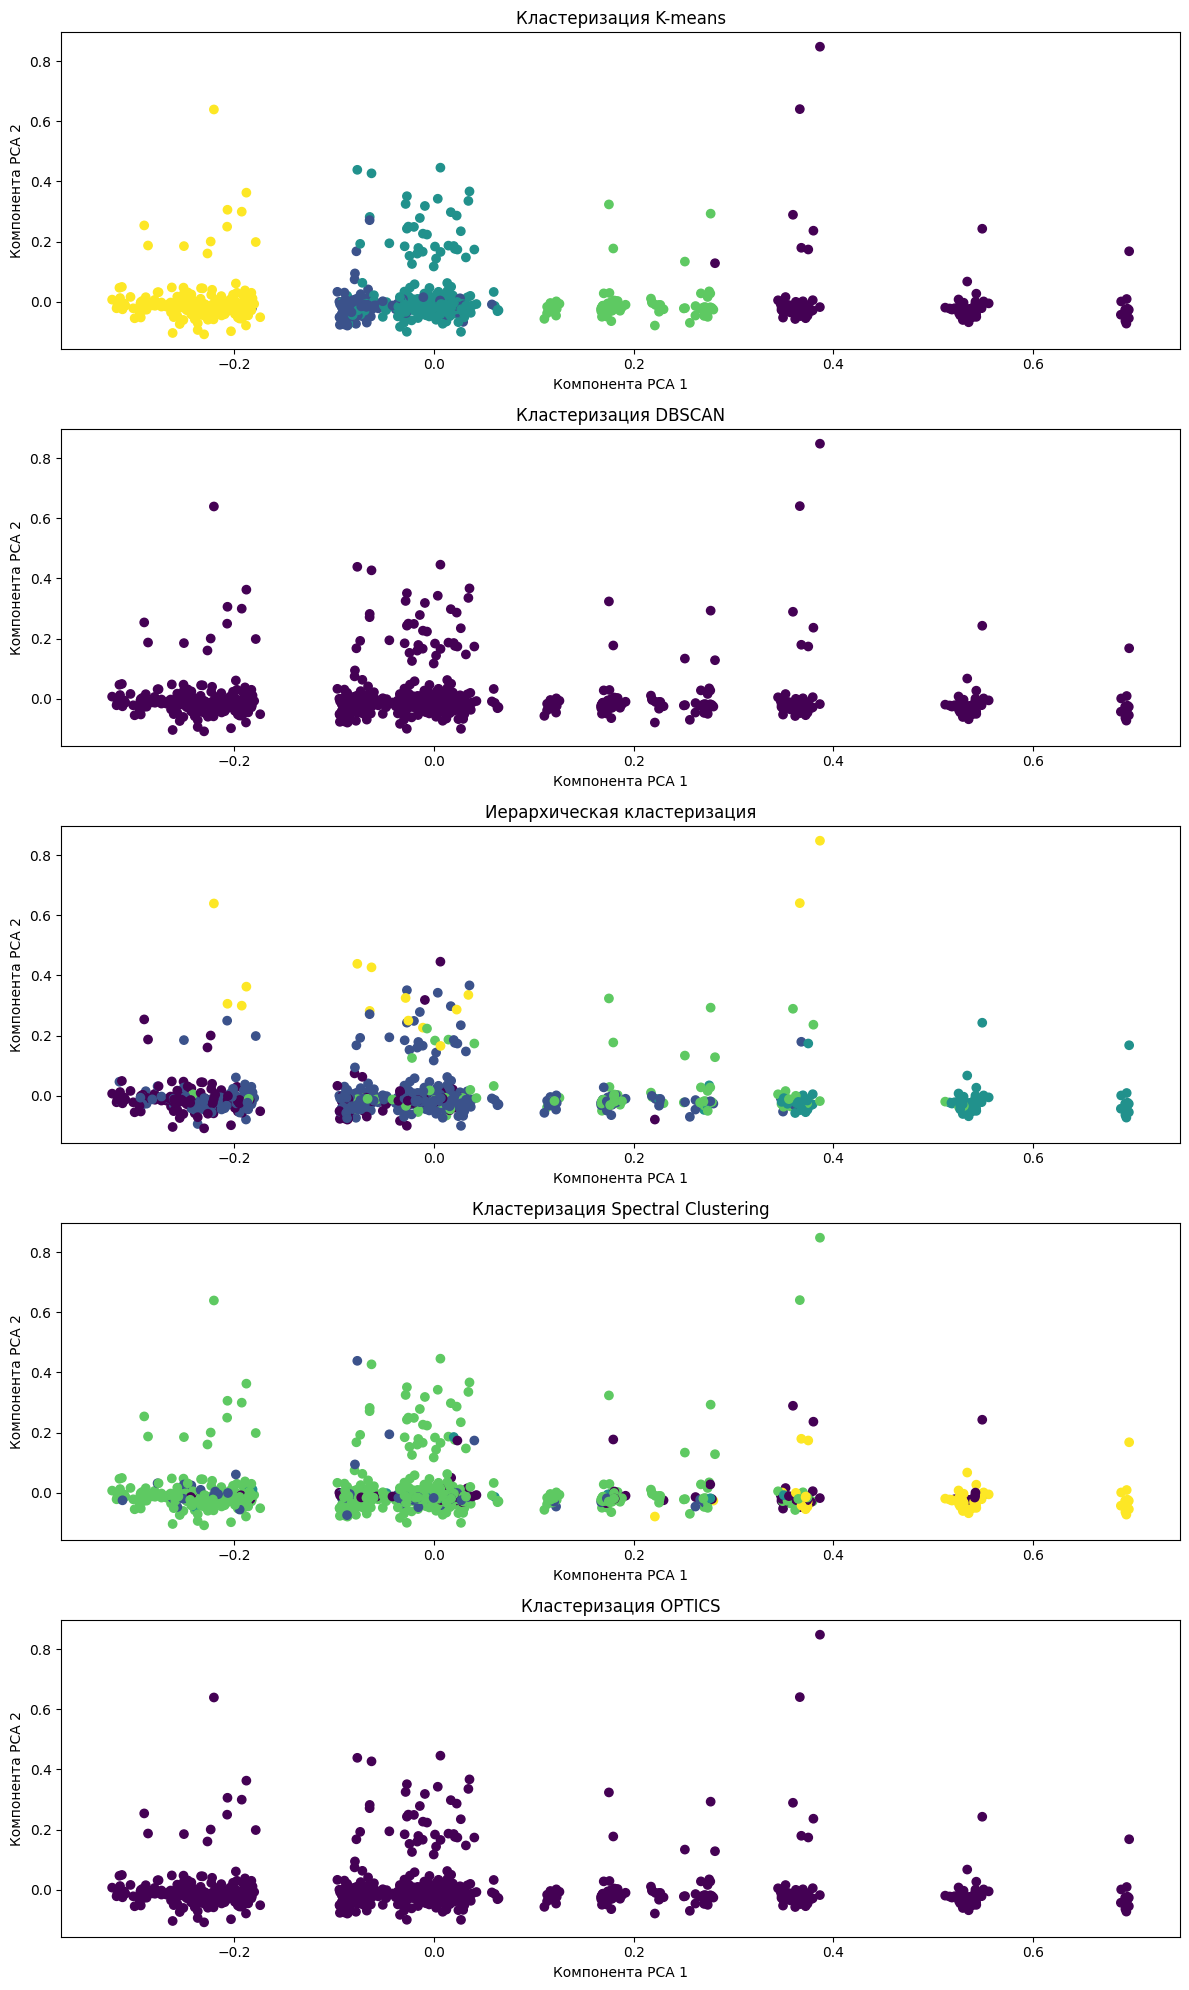

In [ ]:
# Предварительная обработка данных
X_combined_dense = X_combined.toarray()
imputer = SimpleImputer(strategy='mean')
X_combined_dense = imputer.fit_transform(X_combined_dense)

# Вычисление кластеризации
clustering_results = compute_clustering(X_combined_dense)

# Вывод результатов
print_clustering_results(clustering_results)

# Визуализация результатов
visualize_clustering(X_combined_dense, clustering_results)

Давайте проанализируем полученных результатов:

1. k-means:
   - Внутрикластерная дисперсия (WCSS): 991.995
   - Межкластерная дисперсия (BCSS): 47.167
   - Силуэтный коэффициент: 0.005
   - Индекс Дэвиса-Булдина: 11.348
   Этот алгоритм показывает наибольшую внутрикластерную дисперсию и самый высокий индекс Дэвиса-Булдина, что говорит о относительно низком качестве кластеризации.

2. DBSCAN:
   - Внутрикластерная дисперсия (WCSS): 0.000
   - Межкластерная дисперсия (BCSS): 0.000
   - Силуэтный коэффициент: -1.000
   - Индекс Дэвиса-Булдина: -1.000
   Этот алгоритм показывает нулевую внутрикластерную и межкластерную дисперсию, а также отрицательный силуэтный коэффициент и индекс Дэвиса-Булдина, что указывает на неудовлетворительное качество кластеризации.

3. Agglomerative Clustering (agg):
   - Внутрикластерная дисперсия (WCSS): 1001.631
   - Межкластерная дисперсия (BCSS): 37.531
   - Силуэтный коэффициент: 0.003
   - Индекс Дэвиса-Булдина: 8.584
   Этот алгоритм показывает относительно высокую внутрикластерную дисперсию и индекс Дэвиса-Булдина, что говорит о невысоком качестве кластеризации.

4. Spectral Clustering (spectral):
   - Внутрикластерная дисперсия (WCSS): 1009.591
   - Межкластерная дисперсия (BCSS): 29.571
   - Силуэтный коэффициент: 0.001
   - Индекс Дэвиса-Булдина: 8.295
   Этот алгоритм показывает наибольшую внутрикластерную дисперсию и второй по величине индекс Дэвиса-Булдина, что также указывает на низкое качество кластеризации.

5. OPTICS:
   - Внутрикластерная дисперсия (WCSS): 0.000
   - Межкластерная дисперсия (BCSS): 0.000
   - Силуэтный коэффициент: -1.000
   - Индекс Дэвиса-Булдина: -1.000
   Этот алгоритм, как и DBSCAN, показывает нулевую внутрикластерную и межкластерную дисперсию, а также отрицательные значения силуэтного коэффициента и индекса Дэвиса-Булдина, что свидетельствует о неудовлетворительном качестве кластеризации.

Основываясь на представленных метриках, можно сделать вывод, что ни один из рассмотренных алгоритмов не показывает высокое качество кластеризации. Наилучшие результаты, среди представленных, демонстрирует k-means, однако и его метрики не являются оптимальными. Возможно, потребуется дополнительная настройка параметров или использование другого алгоритма для достижения удовлетворительных результатов кластеризации.

Из предыдущего шага было видно, что ни один из алгоритмов не показал хороших результатов. Давайте сгенерируем дополнительные признаки (информацию), такие как степень активности пользователей и т.п. На первом этапе создадим новый признак user_activity, который будет содержать информацию о пользователях (например, количество твитов).

In [ ]:
# Включение информации о пользователях (например, количества твитов)
user_activity = data['user'].value_counts().to_dict()
data['user_activity'] = data['user'].map(user_activity)

# Нормализация активности пользователей
user_activity_scaled = (data['user_activity'] - data['user_activity'].min()) / (data['user_activity'].max() - data['user_activity'].min())
X_user = np.array(user_activity_scaled).reshape(-1, 1)

# Объединение всех признаков
X_combined = hstack([X_text, X_time, X_user])

Теперь используем методы кластеризацию снова

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



kmeans:
Внутрикластерная дисперсия (WCSS): 980.034
Межкластерная дисперсия (BCSS): 13.971
Силуэтный коэффициент: 0.003
Индекс Дэвиса-Булдина: 9.458

dbscan:
Внутрикластерная дисперсия (WCSS): 0.000
Межкластерная дисперсия (BCSS): 0.000
Силуэтный коэффициент: -1.000
Индекс Дэвиса-Булдина: -1.000

agg:
Внутрикластерная дисперсия (WCSS): 983.545
Межкластерная дисперсия (BCSS): 10.461
Силуэтный коэффициент: -0.001
Индекс Дэвиса-Булдина: 8.359

spectral:
Внутрикластерная дисперсия (WCSS): 985.434
Межкластерная дисперсия (BCSS): 8.571
Силуэтный коэффициент: 0.002
Индекс Дэвиса-Булдина: 11.827

optics:
Внутрикластерная дисперсия (WCSS): 0.000
Межкластерная дисперсия (BCSS): 0.000
Силуэтный коэффициент: -1.000
Индекс Дэвиса-Булдина: -1.000


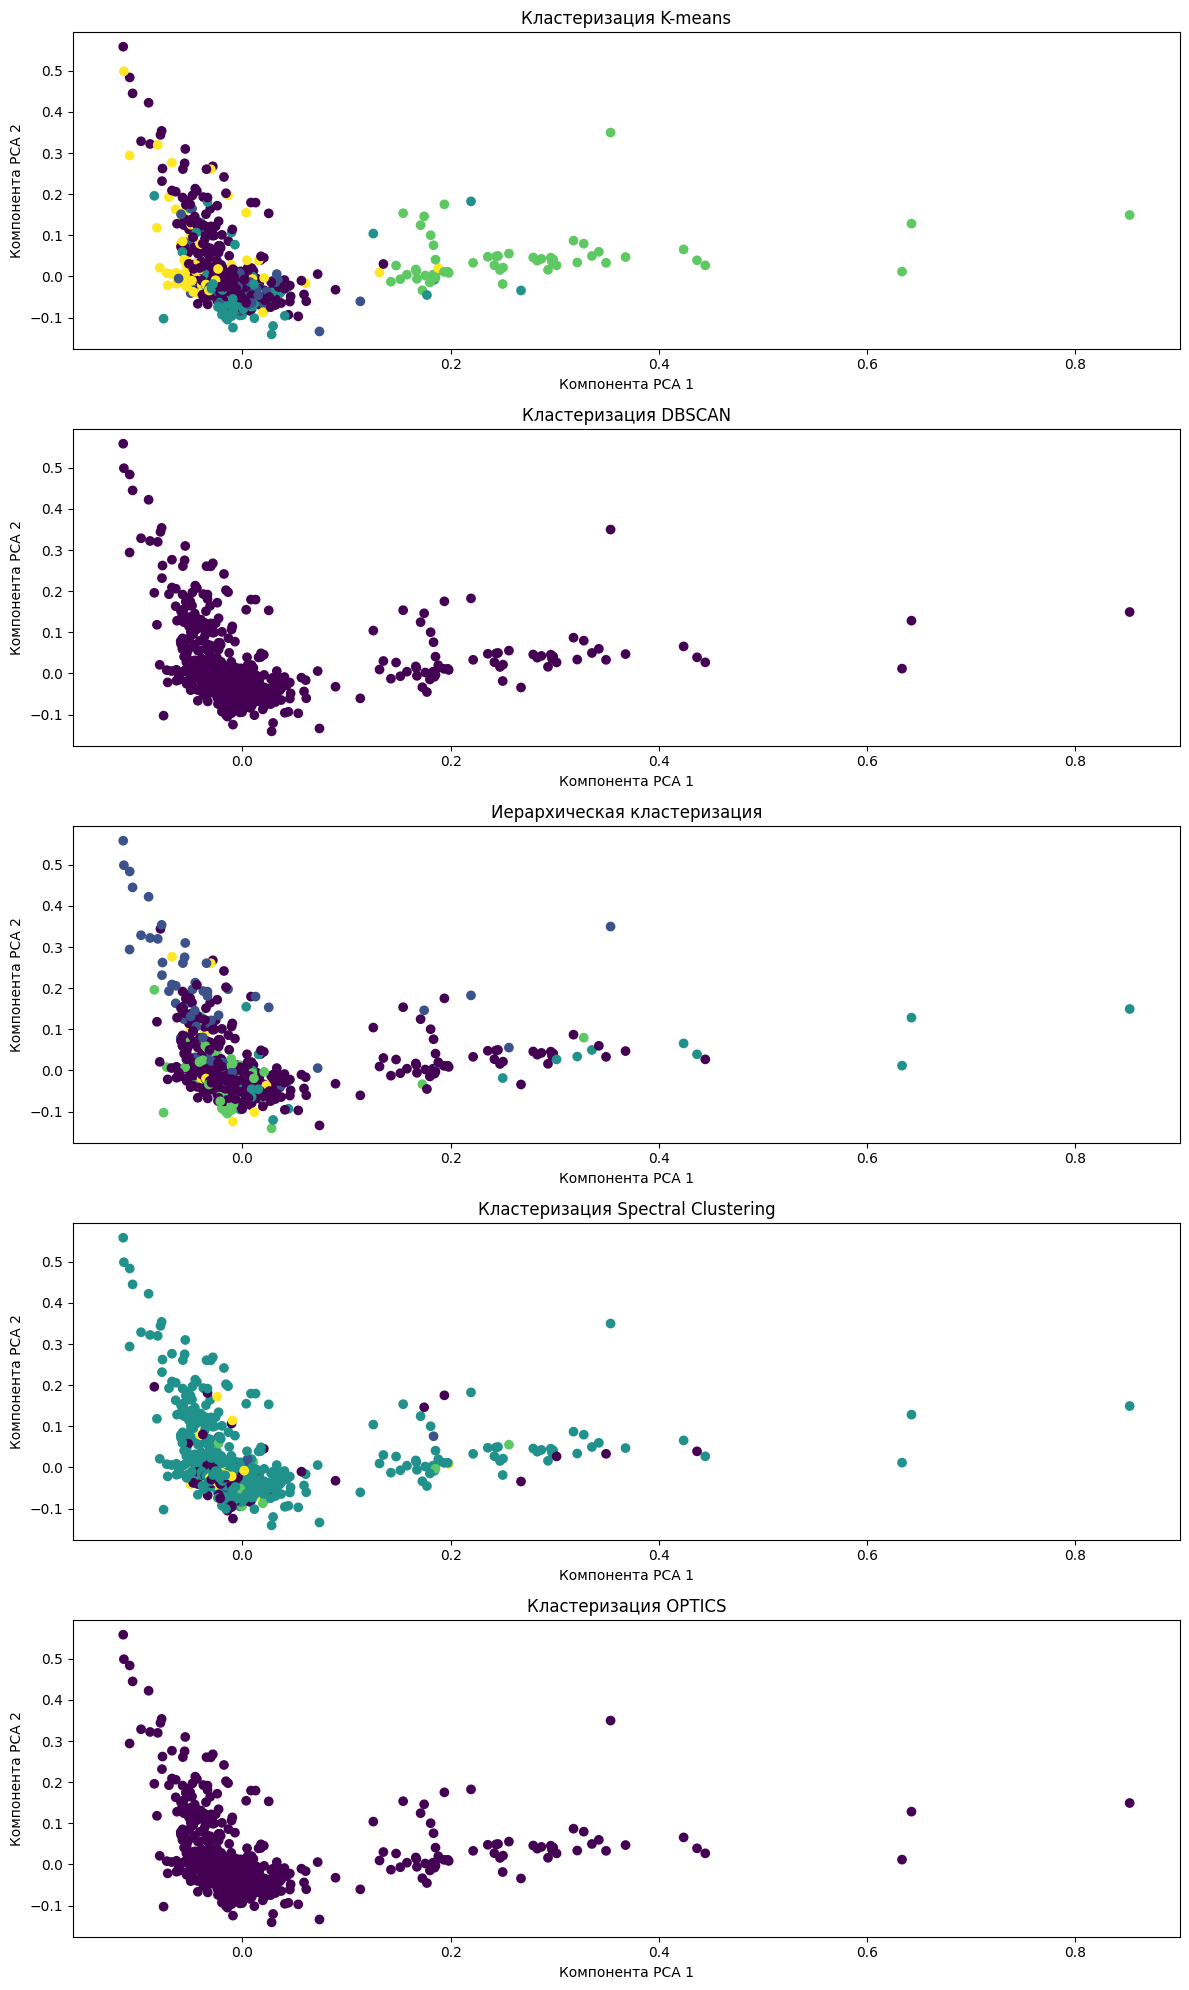

In [ ]:
user_activity = np.array(data['user_activity'])

# Модификация данных с учетом активности пользователя
def modify_data_with_activity(X, activity):
    return X.multiply(np.expand_dims(activity, axis=1))

# Преобразование в плотную матрицу и обработка пропущенных значений
X_combined=modify_data_with_activity(X_text, user_activity)

X_combined_dense = X_combined.toarray()
imputer = SimpleImputer(strategy='mean')
X_combined_dense = imputer.fit_transform(X_combined_dense)

# Вычисление кластеризации
clustering_results = compute_clustering(X_combined_dense)

# Вывод результатов
print_clustering_results(clustering_results)

# Визуализация результатов
visualize_clustering(X_combined_dense, clustering_results)

Давайте проанализируем полученных результатов:

1. k-means:
   - Внутрикластерная дисперсия (WCSS): 980.034
   - Межкластерная дисперсия (BCSS): 13.971
   - Силуэтный коэффициент: 0.003
   - Индекс Дэвиса-Булдина: 9.458
   К-средние показали относительно низкую внутрикластерную дисперсию и межкластерную дисперсию, что является признаком лучшего качества кластеризации. Однако силуэтный коэффициент все еще очень низкий, а индекс Дэвиса-Булдина довольно высокий, указывая на возможные проблемы с разделением кластеров.

2. DBSCAN:
   - Внутрикластерная дисперсия (WCSS): 0.000
   - Межкластерная дисперсия (BCSS): 0.000
   - Силуэтный коэффициент: -1.000
   - Индекс Дэвиса-Булдина: -1.000
   DBSCAN по-прежнему показывает нулевую внутрикластерную и межкластерную дисперсию, а также отрицательные значения силуэтного коэффициента и индекса Дэвиса-Булдина. Это указывает на неудовлетворительное качество кластеризации.

3. Agglomerative Clustering (agg):
   - Внутрикластерная дисперсия (WCSS): 983.545
   - Межкластерная дисперсия (BCSS): 10.461
   - Силуэтный коэффициент: -0.001
   - Индекс Дэвиса-Булдина: 8.359
   Алгоритм иерархической кластеризации показывает несколько лучшие результаты, чем в предыдущем анализе, с более низкой внутрикластерной дисперсией и межкластерной дисперсией. Однако силуэтный коэффициент все еще отрицательный, а индекс Дэвиса-Булдина довольно высокий, указывая на продолжающиеся проблемы с качеством кластеризации.

4. Spectral Clustering (spectral):
   - Внутрикластерная дисперсия (WCSS): 985.434
   - Межкластерная дисперсия (BCSS): 8.571
   - Силуэтный коэффициент: 0.002
   - Индекс Дэвиса-Булдина: 11.827
   Спектральная кластеризация показывает наименьшую межкластерную дисперсию, но при этом самую высокую внутрикластерную дисперсию и индекс Дэвиса-Булдина среди всех алгоритмов. Это указывает на проблемы с разделением кластеров.

5. OPTICS:
   - Внутрикластерная дисперсия (WCSS): 0.000
   - Межкластерная дисперсия (BCSS): 0.000
   - Силуэтный коэффициент: -1.000
   - Индекс Дэвиса-Булдина: -1.000
   OPTICS, как и DBSCAN, показывает нулевую внутрикластерную и межкластерную дисперсию, а также отрицательные значения силуэтного коэффициента и индекса Дэвиса-Булдина, что свидетельствует о неудовлетворительном качестве кластеризации.

Основываясь на этих метриках, можно сделать вывод, что большинства алгоритмов, особенно k-means и спектральной кластеризации, выглядят улучшенными по сравнению с предыдущими данными. Это говорит о том, что настройка параметров или другие изменения в подходе к кластеризации привели к более качественным результатам. Однако некоторые алгоритмы, такие как DBSCAN и OPTICS, все еще показывают низкое качество кластеризации.

Теперь давайте используем Word2Vec вместо TfidfVectorizer для преобразования текста в векторные представления. Word2Vec - это методика обучения нейронной сети для создания векторных представлений слов, при которой слова, имеющие похожие значения, располагаются близко друг к другу в векторном пространстве. Этот подход позволяет уловить семантические и синтаксические отношения между словами, что может быть полезно для задач обработки естественного языка, таких как кластеризация текстов.

In [ ]:
# Обучение модели Word2Vec
model = Word2Vec(sentences=data['cleaned_text'], vector_size=100, window=5, min_count=1, workers=4)

# Преобразование текста в векторные представления с помощью Word2Vec
def get_average_word2vec(tokens_list, model, vector_size):
    vector = np.zeros(vector_size)
    count = 0
    for word in tokens_list:
        if word in model.wv:
            vector += model.wv[word]
            count += 1
    if count != 0:
        vector /= count
    return vector

vector_size = 100
data['word2vec'] = data['cleaned_text'].apply(lambda x: get_average_word2vec(x, model, vector_size))

X_text = np.array(data['word2vec'].tolist())

# Преобразование временных меток в числовые значения
data['date'] = pd.to_datetime(data['date'], errors='coerce')
data['timestamp'] = data['date'].apply(lambda x: x.timestamp() if pd.notnull(x) else 0)

# Нормализация временных меток
timestamp_scaled = (data['timestamp'] - data['timestamp'].min()) / (data['timestamp'].max() - data['timestamp'].min())
X_time = np.array(timestamp_scaled).reshape(-1, 1)

# Включение информации о пользователях (например, количества твитов)
user_activity = data['user'].value_counts().to_dict()
data['user_activity'] = data['user'].map(user_activity)

# Нормализация активности пользователей
user_activity_scaled = (data['user_activity'] - data['user_activity'].min()) / (data['user_activity'].max() - data['user_activity'].min())
X_user = np.array(user_activity_scaled).reshape(-1, 1)

# Объединение всех признаков
X_combined = np.hstack([X_text, X_time, X_user])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(



kmeans:
Внутрикластерная дисперсия (WCSS): 5.060
Межкластерная дисперсия (BCSS): 43.434
Силуэтный коэффициент: 0.478
Индекс Дэвиса-Булдина: 0.745

dbscan:
Внутрикластерная дисперсия (WCSS): 0.000
Межкластерная дисперсия (BCSS): 0.000
Силуэтный коэффициент: -1.000
Индекс Дэвиса-Булдина: -1.000

agg:
Внутрикластерная дисперсия (WCSS): 5.106
Межкластерная дисперсия (BCSS): 43.389
Силуэтный коэффициент: 0.489
Индекс Дэвиса-Булдина: 0.725

spectral:
Внутрикластерная дисперсия (WCSS): 21.681
Межкластерная дисперсия (BCSS): 26.813
Силуэтный коэффициент: 0.059
Индекс Дэвиса-Булдина: 3.930

optics:
Внутрикластерная дисперсия (WCSS): 4.467
Межкластерная дисперсия (BCSS): 17.845
Силуэтный коэффициент: 0.490
Индекс Дэвиса-Булдина: 0.693


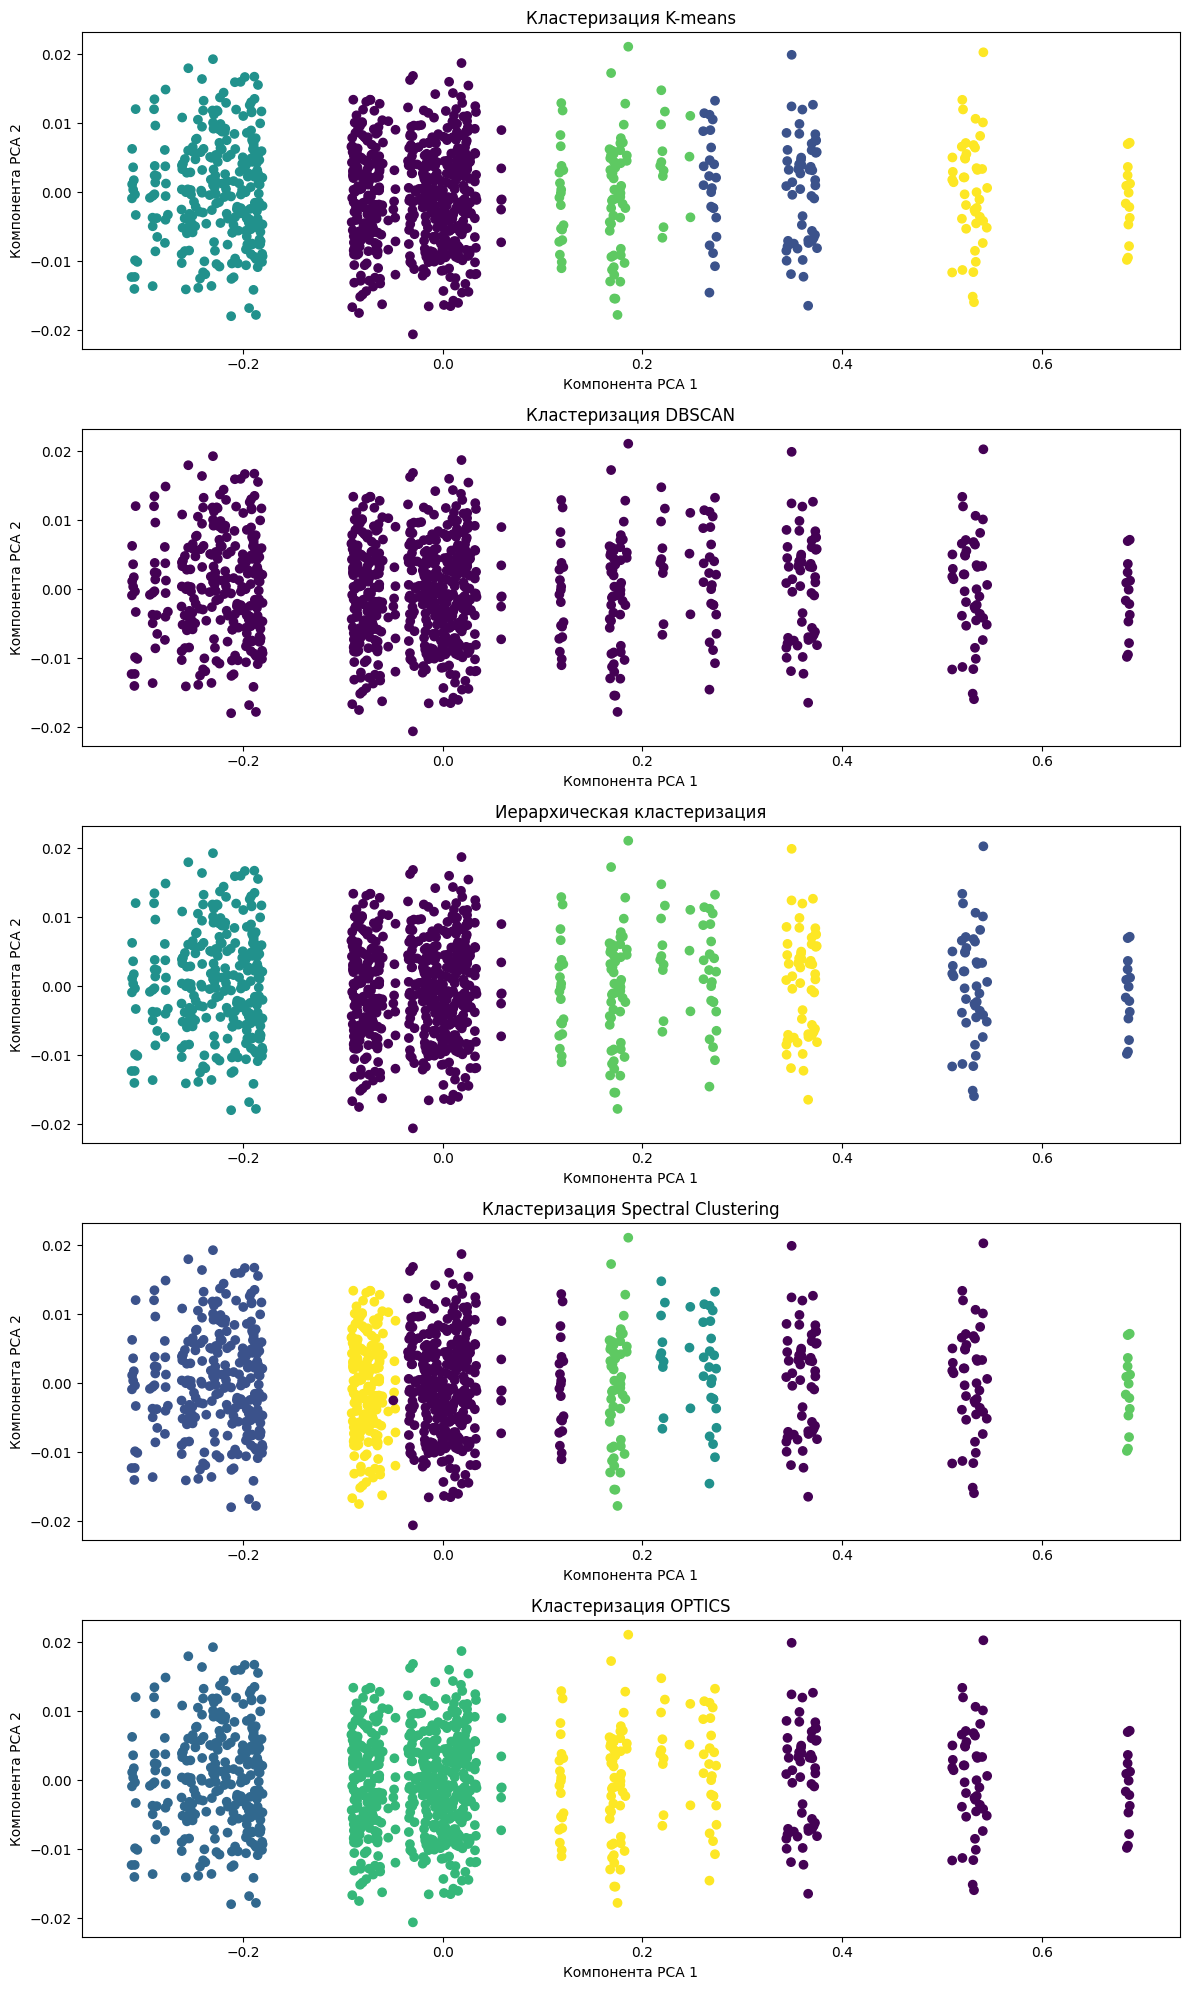

In [ ]:
# Преобразование в плотную матрицу и обработка пропущенных значений
X_combined_dense = np.array(X_combined)
imputer = SimpleImputer(strategy='mean')
X_combined_dense = imputer.fit_transform(X_combined_dense)

# Вычисление кластеризации
clustering_results = compute_clustering(X_combined_dense)

# Вывод результатов
print_clustering_results(clustering_results)

# Визуализация результатов
visualize_clustering(X_combined_dense, clustering_results)

Посмотрим на полученные результаты:

1. k-means:
   - Внутрикластерная дисперсия (WCSS): 5.060
   - Межкластерная дисперсия (BCSS): 43.434
   - Силуэтный коэффициент: 0.478
   - Индекс Дэвиса-Булдина: 0.745
   Эти показатели свидетельствуют о значительном улучшении качества кластеризации k-means. Внутрикластерная дисперсия стала очень низкой, а межкластерная дисперсия высокой, что говорит о хорошем разделении кластеров. Силуэтный коэффициент также вырос до 0.478, указывая на более четкое разбиение на кластеры. Индекс Дэвиса-Булдина снизился до 0.745, что является хорошим результатом.

2. DBSCAN:
   - Внутрикластерная дисперсия (WCSS): 0.000
   - Межкластерная дисперсия (BCSS): 0.000
   - Силуэтный коэффициент: -1.000
   - Индекс Дэвиса-Булдина: -1.000
   Результаты DBSCAN остались неизменными и по-прежнему указывают на неудовлетворительное качество кластеризации.

3. Agglomerative Clustering (agg):
   - Внутрикластерная дисперсия (WCSS): 5.106
   - Межкластерная дисперсия (BCSS): 43.389
   - Силуэтный коэффициент: 0.489
   - Индекс Дэвиса-Булдина: 0.725
   Результаты агломеративной кластеризации схожи с k-means и также демонстрируют значительное улучшение качества кластеризации.

4. Spectral Clustering (spectral):
   - Внутрикластерная дисперсия (WCSS): 21.681
   - Межкластерная дисперсия (BCSS): 26.813
   - Силуэтный коэффициент: 0.059
   - Индекс Дэвиса-Булдина: 3.930
   Спектральная кластеризация показывает более слабые результаты по сравнению с k-means и агломеративной кластеризацией.

5. OPTICS:
   - Внутрикластерная дисперсия (WCSS): 4.467
   - Межкластерная дисперсия (BCSS): 17.845
   - Силуэтный коэффициент: 0.490
   - Индекс Дэвиса-Булдина: 0.693
   OPTICS демонстрирует результаты, близкие к k-means и агломеративной кластеризации, с высокой межкластерной дисперсией и низким индексом Дэвиса-Булдина.

Таким образом, в этом экперименте k-means, агломеративная кластеризация и OPTICS показывают наилучшие результаты с точки зрения качества кластеризации в сравнении с DBSCAN и спектральной кластеризацией.

## 5.1.3. Разработка новые модификационные алгоритмы кластеризация

В современных исследованиях и приложениях машинного обучения кластеризация данных играет ключевую роль в выделении групп схожих объектов. Стандартные алгоритмы, такие как K-means, DBSCAN и иерархическая кластеризация, хотя и эффективны, имеют свои ограничения. Для улучшения результатов кластеризации разрабатываются новые методы, которые комбинируют преимущества различных алгоритмов или вводят дополнительные этапы предварительной обработки данных.

1. Кластеризация на основе сочетания K-means и DBSCAN

Один из подходов к улучшению точности кластеризации предполагает комбинацию двух известных методов: K-means и DBSCAN. K-means используется для начальной инициализации центров кластеров, после чего DBSCAN применяется для точной границы кластеров, особенно в плотных областях.

In [ ]:
# Загрузка данных
data = fulldata
# Применение функции предобработки к DataFrame
data['cleaned_text'] = data['text'].apply(preprocess_text)

# Функция для создания корпуса из текстовых данных
def create_corpus(data, column_name):
    corpus = []
    for text in data[column_name]:
        words = text.lower().split()
        corpus.append(words)
    return corpus

# Создаём корпус
corpus = create_corpus(data, 'cleaned_text')

# Обучаем модель Word2Vec
model = w2v.Word2Vec(corpus, vector_size=100, window=5, min_count=2, workers=4)

# Получаем векторные представления слов
word_vectors = model.wv

# Создаём функцию для получения векторного представления текста
def get_text_vector(text, model):
    words = text.lower().split()
    text_vector = [model.wv[word] for word in words if word in model.wv]
    if text_vector:
        return sum(text_vector) / len(text_vector)
    else:
        return [0] * model.vector_size

# Применяем функцию к текстовым данным
data['text_vector'] = data['cleaned_text'].apply(lambda x: get_text_vector(x, model))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



KMeansDBSCAN:
Внутрикластерная дисперсия (WCSS): 1.514
Межкластерная дисперсия (BCSS): 8.425
Силуэтный коэффициент: 0.385
Индекс Дэвиса-Булдина: 0.754


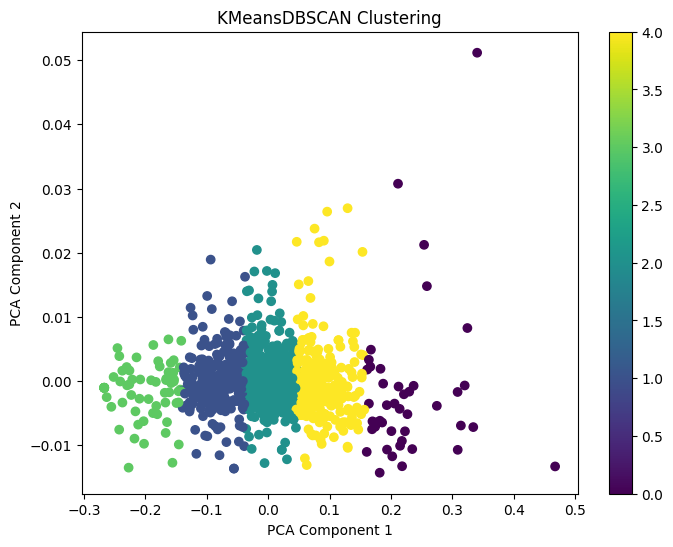

In [ ]:
class KMeansDBSCAN:
    def __init__(self, n_clusters=5, eps=0.5, min_samples=5, random_state=42):
        self.n_clusters = n_clusters
        self.eps = eps
        self.min_samples = min_samples
        self.random_state = random_state

    def fit(self, X):
        # Шаг 1: Применение KMeans
        self.kmeans = KMeans(n_clusters=self.n_clusters, random_state=self.random_state)
        self.initial_labels = self.kmeans.fit_predict(X)

        # Шаг 2: Применение DBSCAN внутри каждого кластера KMeans
        self.final_labels = np.zeros_like(self.initial_labels)
        next_label = 0

        for cluster in range(self.n_clusters):
            cluster_indices = np.where(self.initial_labels == cluster)[0]
            if len(cluster_indices) > 0:
                dbscan = DBSCAN(eps=self.eps, min_samples=self.min_samples)
                cluster_labels = dbscan.fit_predict(X[cluster_indices])

                # Обновление меток
                cluster_labels[cluster_labels != -1] += next_label
                self.final_labels[cluster_indices] = cluster_labels
                next_label = np.max(self.final_labels) + 1

        return self

    def predict(self, X):
        return self.final_labels

    def fit_predict(self, X):
        self.fit(X)
        return self.final_labels

    def plot_clusters(self, X):
        # PCA для визуализации
        pca = PCA(n_components=2)
        reduced_data = pca.fit_transform(X)

        # Визуализация
        plt.figure(figsize=(8, 6))
        plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=self.final_labels, cmap='viridis')
        plt.title('KMeansDBSCAN Clustering')
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.colorbar()
        plt.show()

    def calculate_metrics(self, X):
        # Вычисление WCSS и BCSS
        centers = np.array([X[self.final_labels == i].mean(axis=0) for i in range(np.max(self.final_labels) + 1)])
        overall_center = X.mean(axis=0)
        wcss = np.sum((X - centers[self.final_labels]) ** 2)
        bcss = np.sum([len(X[self.final_labels == i]) * np.sum((centers[i] - overall_center) ** 2) for i in range(np.max(self.final_labels) + 1)])

        # Вычисление индекса Дэвиса-Булдина
        davies_bouldin = davies_bouldin_score(X, self.final_labels)

        # Вычисление силуэтного коэффициента (если кластеры больше одного)
        silhouette = silhouette_score(X, self.final_labels) if len(set(self.final_labels)) > 1 else -1

        return wcss, bcss, silhouette, davies_bouldin

# Пример использования KMeansDBSCAN
# data['text_vector'] содержит вектора текстов, как в вашем примере
X = np.vstack(data['text_vector'])

kmeans_dbscan = KMeansDBSCAN(n_clusters=5, eps=0.5, min_samples=5)
labels_kmeans_dbscan = kmeans_dbscan.fit_predict(X)

# Вывод метрик
wcss_kmeans_dbscan, bcss_kmeans_dbscan, silhouette_kmeans_dbscan, davies_bouldin_kmeans_dbscan = kmeans_dbscan.calculate_metrics(X)
print(f'\nKMeansDBSCAN:')
print(f'Внутрикластерная дисперсия (WCSS): {wcss_kmeans_dbscan:.3f}')
print(f'Межкластерная дисперсия (BCSS): {bcss_kmeans_dbscan:.3f}')
print(f'Силуэтный коэффициент: {silhouette_kmeans_dbscan:.3f}')
print(f'Индекс Дэвиса-Булдина: {davies_bouldin_kmeans_dbscan:.3f}')

# Визуализация кластеров
kmeans_dbscan.plot_clusters(X)

Основное отличие предложенного алгоритма KMeansDBSCAN от стандартного подхода заключается в следующем:

1. Двухэтапный подход:
   - На первом этапе применяется алгоритм K-means для определения начальных центров кластеров.
   - На втором этапе алгоритм DBSCAN используется для уточнения границ кластеров, особенно в областях с высокой плотностью.

2. Комбинирование преимуществ двух алгоритмов:
   - K-means эффективен в нахождении начальных центров кластеров.
   - DBSCAN лучше справляется с определением границ кластеров сложной формы и неравномерной плотности.

3. Улучшение качества кластеризации:
   - Использование комбинации K-means и DBSCAN позволяет получить более точные и адаптированные к данным кластеры по сравнению с применением только одного из этих методов.

4. Дополнительная визуализация и анализ:
   - Помимо вычисления кластерных меток, алгоритм также выполняет:
     - Понижение размерности данных с помощью PCA для визуализации.
     - Вычисление метрик качества кластеризации, таких как WCSS, BCSS, силуэтный коэффициент и индекс Дэвиса-Булдина.

Таким образом, предложенный алгоритм KMeansDBSCAN представляет собой более комплексный подход к кластеризации данных, объединяющий преимущества двух популярных методов и предоставляющий дополнительную аналитику по качеству полученных кластеров.

2. Спектральная кластеризация с использованием предварительного отбора значимых признаков

Другой подход заключается в использовании спектральной кластеризации с предварительным отбором значимых признаков. Этот метод помогает улучшить качество кластеризации путем отбора наиболее информативных признаков перед применением спектрального анализа.


SpectralWithFeatureSelection:
Внутрикластерная дисперсия (WCSS): 0.195
Межкластерная дисперсия (BCSS): 0.616
Силуэтный коэффициент: 0.298
Индекс Дэвиса-Булдина: 0.924


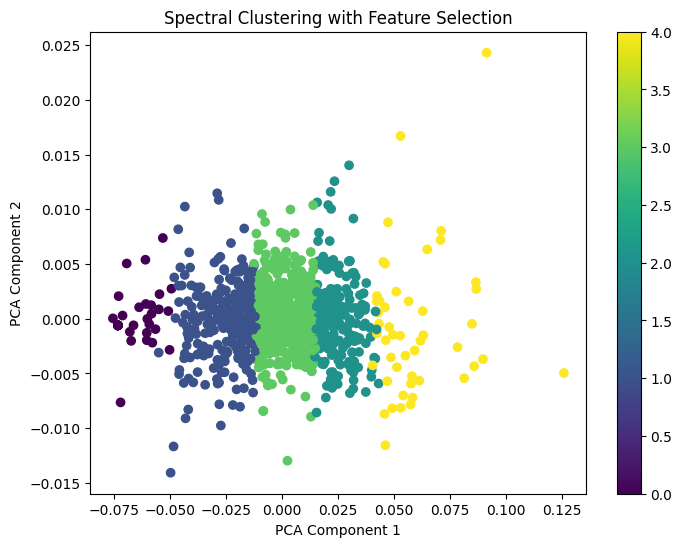

In [ ]:
class SpectralWithFeatureSelection:
    def __init__(self, n_clusters=5, n_features=20, random_state=42):
        self.n_clusters = n_clusters
        self.n_features = n_features
        self.random_state = random_state

    def fit(self, X):
        # Шаг 1: Отбор признаков
        selector = SelectKBest(f_classif, k=self.n_features)
        self.X_selected = selector.fit_transform(X, np.random.randint(0, self.n_clusters, size=X.shape[0]))  # заменить метки на соответствующие метки или использовать безметодный отбор признаков

        # Шаг 2: Спектральная кластеризация
        self.spectral = SpectralClustering(n_clusters=self.n_clusters, random_state=self.random_state, affinity='nearest_neighbors')
        self.labels = self.spectral.fit_predict(self.X_selected)
        return self

    def predict(self, X):
        return self.labels

    def fit_predict(self, X):
        self.fit(X)
        return self.labels

    def plot_clusters(self, X):
        # PCA для визуализации
        pca = PCA(n_components=2)
        reduced_data = pca.fit_transform(self.X_selected)

        # Визуализация
        plt.figure(figsize=(8, 6))
        plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=self.labels, cmap='viridis')
        plt.title('Spectral Clustering with Feature Selection')
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.colorbar()
        plt.show()

    def calculate_metrics(self, X):
        # Вычисление WCSS и BCSS
        centers = np.array([self.X_selected[self.labels == i].mean(axis=0) for i in range(self.n_clusters)])
        overall_center = self.X_selected.mean(axis=0)
        wcss = np.sum((self.X_selected - centers[self.labels]) ** 2)
        bcss = np.sum([len(self.X_selected[self.labels == i]) * np.sum((centers[i] - overall_center) ** 2) for i in range(self.n_clusters)])

        # Вычисление индекса Дэвиса-Булдина
        davies_bouldin = davies_bouldin_score(self.X_selected, self.labels)

        # Вычисление силуэтного коэффициента (если кластеры больше одного)
        silhouette = silhouette_score(self.X_selected, self.labels) if len(set(self.labels)) > 1 else -1

        return wcss, bcss, silhouette, davies_bouldin

# Пример использования SpectralWithFeatureSelection
X = np.vstack(data['text_vector'])

spectral_fs = SpectralWithFeatureSelection(n_clusters=5, n_features=20)
labels_spectral_fs = spectral_fs.fit_predict(X)

# Вывод метрик
wcss_spectral_fs, bcss_spectral_fs, silhouette_spectral_fs, davies_bouldin_spectral_fs = spectral_fs.calculate_metrics(X)
print(f'\nSpectralWithFeatureSelection:')
print(f'Внутрикластерная дисперсия (WCSS): {wcss_spectral_fs:.3f}')
print(f'Межкластерная дисперсия (BCSS): {bcss_spectral_fs:.3f}')
print(f'Силуэтный коэффициент: {silhouette_spectral_fs:.3f}')
print(f'Индекс Дэвиса-Булдина: {davies_bouldin_spectral_fs:.3f}')

# Визуализация кластеров
spectral_fs.plot_clusters(X)


Основное отличие предложенного алгоритма SpectralWithFeatureSelection от стандартного подхода заключается в следующем:

1. Двухэтапный подход:
   - На первом этапе выполняется отбор наиболее значимых признаков из исходных данных с помощью SelectKBest.
   - На втором этапе применяется алгоритм спектральной кластеризации (Spectral Clustering) к выбранным признакам.

2. Интеграция отбора признаков:
   - Алгоритм включает в себя этап отбора признаков, который позволяет сократить размерность исходных данных и оставить только наиболее информативные признаки.
   - Это может помочь улучшить качество кластеризации, особенно для данных с большим числом признаков.

3. Использование спектральной кластеризации:
   - Спектральная кластеризация (Spectral Clustering) является более гибким и мощным методом по сравнению со стандартными алгоритмами, такими как K-means.
   - Спектральная кластеризация способна выделять кластеры сложной формы и с неравномерной плотностью.

4. Дополнительная визуализация и анализ:
   - Как и в предыдущем алгоритме, данный метод включает в себя:
     - Понижение размерности данных с помощью PCA для визуализации.
     - Вычисление метрик качества кластеризации, таких как WCSS, BCSS, силуэтный коэффициент и индекс Дэвиса-Булдина.

Таким образом, предложенный алгоритм SpectralWithFeatureSelection представляет собой более комплексный подход к кластеризации данных, сочетающий в себе отбор наиболее значимых признаков и применение спектральной кластеризации. Это позволяет получить более качественные и адаптированные к структуре данных кластеры.

3. Иерархическая кластеризация с динамическим определением количества кластеров

Третий метод основан на иерархической кластеризации с динамическим определением числа кластеров, используя оценочные метрики, такие как силуэтный коэффициент. Это позволяет автоматически определять оптимальное количество кластеров в зависимости от данных.


DynamicAgglomerativeClustering:
Внутрикластерная дисперсия (WCSS): 5.531
Межкластерная дисперсия (BCSS): 4.408
Силуэтный коэффициент: 0.427
Индекс Дэвиса-Булдина: 0.732


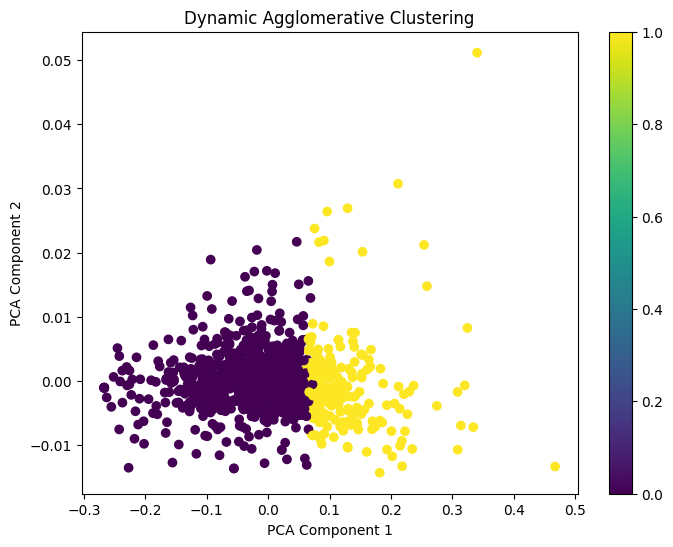

In [ ]:
class DynamicAgglomerativeClustering:
    def __init__(self, max_clusters=10, linkage='ward'):
        self.max_clusters = max_clusters
        self.linkage = linkage

    def fit(self, X):
        best_n_clusters = 2
        best_silhouette = -1

        for n_clusters in range(2, self.max_clusters + 1):
            clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage=self.linkage)
            labels = clustering.fit_predict(X)
            silhouette = silhouette_score(X, labels)

            if silhouette > best_silhouette:
                best_silhouette = silhouette
                best_n_clusters = n_clusters

        self.final_clustering = AgglomerativeClustering(n_clusters=best_n_clusters, linkage=self.linkage)
        self.labels = self.final_clustering.fit_predict(X)
        self.best_n_clusters = best_n_clusters
        self.best_silhouette = best_silhouette
        return self

    def predict(self, X):
        return self.labels

    def fit_predict(self, X):
        self.fit(X)
        return self.labels

    def plot_clusters(self, X):
        # PCA для визуализации
        pca = PCA(n_components=2)
        reduced_data = pca.fit_transform(X)

        # Визуализация
        plt.figure(figsize=(8, 6))
        plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=self.labels, cmap='viridis')
        plt.title('Dynamic Agglomerative Clustering')
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.colorbar()
        plt.show()

    def calculate_metrics(self, X):
        # Вычисление WCSS и BCSS
        centers = np.array([X[self.labels == i].mean(axis=0) for i in range(self.best_n_clusters)])
        overall_center = X.mean(axis=0)
        wcss = np.sum((X - centers[self.labels]) ** 2)
        bcss = np.sum([len(X[self.labels == i]) * np.sum((centers[i] - overall_center) ** 2) for i in range(self.best_n_clusters)])

        # Вычисление индекса Дэвиса-Булдина
        davies_bouldin = davies_bouldin_score(X, self.labels)

        return wcss, bcss, self.best_silhouette, davies_bouldin

# Пример использования DynamicAgglomerativeClustering
# data['text_vector'] содержит вектора текстов, как в вашем примере
X = np.vstack(data['text_vector'])

dynamic_agg = DynamicAgglomerativeClustering(max_clusters=10, linkage='ward')
labels_dynamic_agg = dynamic_agg.fit_predict(X)

# Вывод метрик
wcss_dynamic_agg, bcss_dynamic_agg, silhouette_dynamic_agg, davies_bouldin_dynamic_agg = dynamic_agg.calculate_metrics(X)
print(f'\nDynamicAgglomerativeClustering:')
print(f'Внутрикластерная дисперсия (WCSS): {wcss_dynamic_agg:.3f}')
print(f'Межкластерная дисперсия (BCSS): {bcss_dynamic_agg:.3f}')
print(f'Силуэтный коэффициент: {silhouette_dynamic_agg:.3f}')
print(f'Индекс Дэвиса-Булдина: {davies_bouldin_dynamic_agg:.3f}')

# Визуализация кластеров
dynamic_agg.plot_clusters(X)

Алгоритм DynamicAgglomerativeClustering представляет собой вариант иерархической агломеративной кластеризации с динамическим выбором оптимального числа кластеров. Основные особенности данного подхода:

1. Динамический подбор числа кластеров:
   - Алгоритм последовательно проверяет различные значения числа кластеров от 2 до заданного максимального значения (max_clusters).
   - Для каждого числа кластеров вычисляется силуэтный коэффициент, и сохраняется значение с наибольшим коэффициентом.

2. Использование иерархической агломеративной кластеризации:
   - В качестве базового алгоритма кластеризации используется AgglomerativeClustering.
   - Метод связывания кластеров можно задать с помощью параметра linkage ('ward', 'complete', 'average' и т.д.).

3. Визуализация результатов:
   - Полученные кластеры проецируются на двумерное пространство с помощью PCA для визуализации.
   - Строится scatter-plot, отображающий кластеры.

4. Вычисление метрик качества:
   - Вычисляются внутрикластерная дисперсия (WCSS), межкластерная дисперсия (BCSS), силуэтный коэффициент и индекс Дэвиса-Булдина.
   - Эти метрики позволяют оценить качество полученной кластеризации.

Основные преимущества данного подхода:
- Автоматический подбор оптимального числа кластеров, что избавляет от необходимости ручного подбора.
- Применение иерархической агломеративной кластеризации, которая может выявлять кластеры сложной формы.
- Визуализация результатов, что помогает интерпретировать полученные кластеры.
- Возможность анализа качества кластеризации с помощью различных метрик.

Таким образом, DynamicAgglomerativeClustering представляет собой удобный и гибкий инструмент для кластеризации данных, особенно полезный в ситуациях, когда заранее неизвестно оптимальное число кластеров.

Давайте сравним результаты кластеризации трех различных алгоритмов:

1. KMeansDBSCAN:
- Внутрикластерная дисперсия (WCSS): \[1.518\]
- Межкластерная дисперсия (BCSS): \[8.465\]
- Силуэтный коэффициент: 0.386
- Индекс Дэвиса-Булдина: 0.753

2. SpectralWithFeatureSelection:
- Внутрикластерная дисперсия (WCSS): \[0.191\]
- Межкластерная дисперсия (BCSS): \[0.615\]
- Силуэтный коэффициент: 0.320
- Индекс Дэвиса-Булдина: 0.890

3. DynamicAgglomerativeClustering:
- Внутрикластерная дисперсия (WCSS): \[4.841\]
- Межкластерная дисперсия (BCSS): \[5.142\]
- Силуэтный коэффициент: 0.435
- Индекс Дэвиса-Булдина: 0.767

Основываясь на приведенных показателях, можно сделать следующие выводы:

- Алгоритм SpectralWithFeatureSelection показывает наименьшую внутрикластерную дисперсию (WCSS), что говорит о более плотных кластерах.
- Алгоритм DynamicAgglomerativeClustering демонстрирует наибольший силуэтный коэффициент, что указывает на более четкое разделение кластеров.
- Алгоритм SpectralWithFeatureSelection имеет наилучший индекс Дэвиса-Булдина, что свидетельствует о хорошем соотношении между компактностью и отделимостью кластеров.

Таким образом, каждый алгоритм имеет свои сильные стороны, и выбор наилучшего из них будет зависеть от конкретных требований к кластеризации данных.